# Visualisation des données

## Importation des données

In [126]:
import pickle,zlib,pandas as pd

player_stats_fbref=pickle.loads(zlib.decompress(open('fbref_data/compressed_player_stats_fbref_1.bin','rb').read()))
player_stats_fbref.update(pickle.loads(zlib.decompress(open('fbref_data/compressed_player_stats_fbref_2.bin','rb').read())))
player_stats_fbref=pd.DataFrame(player_stats_fbref).transpose()
player_stats_fbref=player_stats_fbref.sort_index(axis=1,ascending=False)
na_player_stats_fbref=player_stats_fbref.isna()

teams_fbref=pickle.load(open('fbref_data/teams_fbref.pkl','rb'))

glossary=pd.read_csv('fbref_data/Glossaire_FBREF.csv')


player_stats_tm=pd.DataFrame(pickle.load(open('tm_data/player_stats_tm.pkl','rb'))).transpose()



transfer_history=pickle.load(open('tm_data/transfer_history.pkl','rb'))
player_ratings=pd.read_csv('sf_data/player_ratings.csv',index_col=0)



global_team_stats_fbref=pd.DataFrame(pickle.load(open('fbref_data/global_team_stats_fbref.pkl','rb'))).transpose()
global_team_stats_fbref.columns=list(map(lambda s:f'{s}-{s+1}',global_team_stats_fbref.columns))
na_global_team_stats=global_team_stats_fbref.isna()




## Données générales sur la base de données

### Kernel density plot de l'âge des joueurs

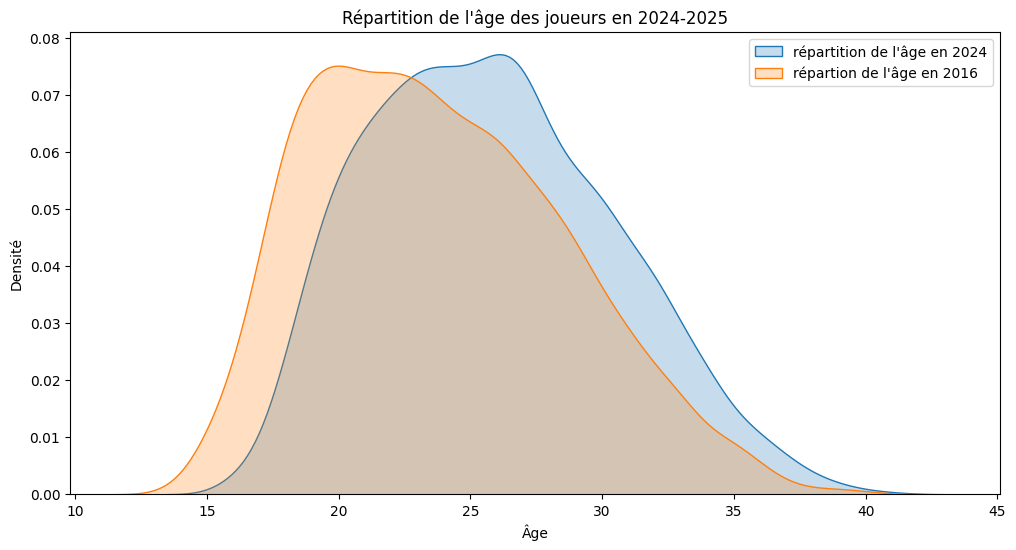

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns

age_2024=list(filter(lambda x: type(x)==float,[player_stats_fbref.loc[player,'2024-2025']['age'] for player in player_stats_fbref.index if not(na_player_stats_fbref.loc[player,'2024-2025'])]))
age_2016=list(filter(lambda x: type(x)==float,[player_stats_fbref.loc[player,'2016-2017']['age'] for player in player_stats_fbref.index if not(na_player_stats_fbref.loc[player,'2016-2017'])]))




plt.figure(figsize=(12, 6))
sns.kdeplot(age_2024, fill=True,label="répartition de l'âge en 2024")
sns.kdeplot(age_2016, fill=True,label="répartion de l'âge en 2016")
plt.title('Répartition de l\'âge des joueurs en 2024-2025')
plt.xlabel('Âge')
plt.ylabel('Densité')
plt.legend()
plt.show()

#### On observe que l'âge moyen des joueurs a avancé entre 2016 et aujourd'hui

### Nombre de joueurs en fonction du championnat

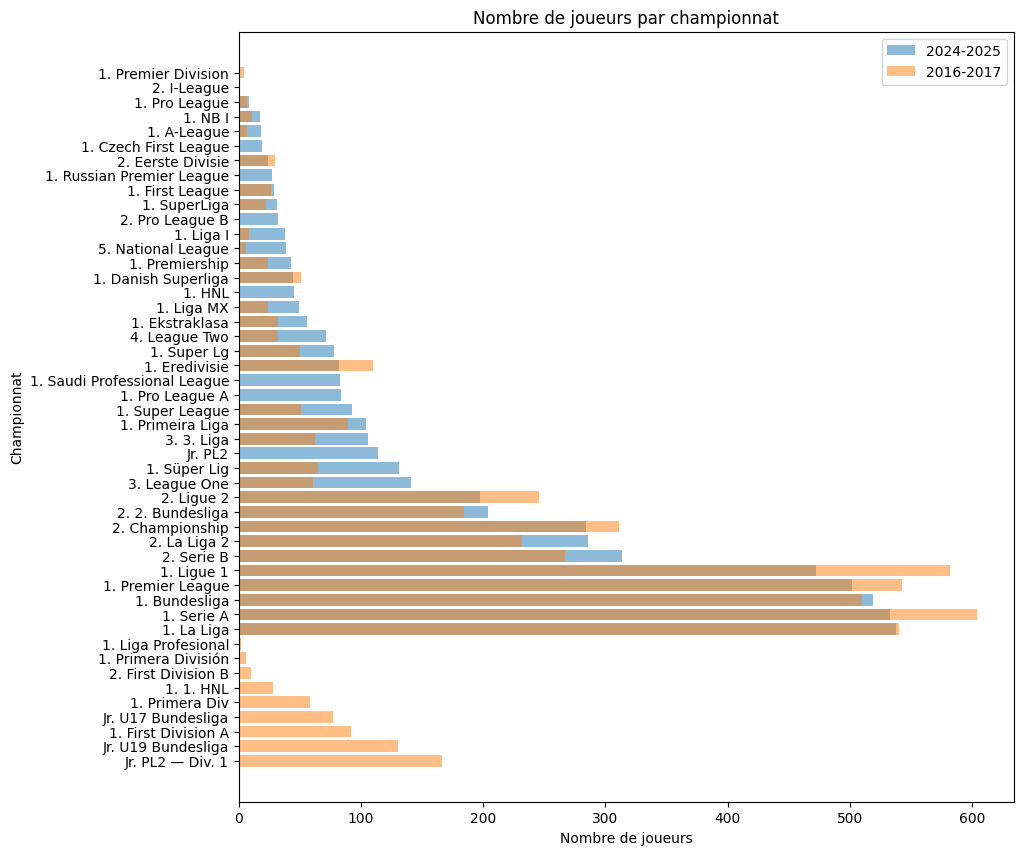

In [82]:
plt.figure(figsize=(10, 10))

for season,color in [('2024-2025','skyblue'),('2016-2017','orange')]:

    champs=[player_stats_fbref.loc[player,season]['comp_level'] for player in player_stats_fbref.index  if not(na_player_stats_fbref.loc[player,season])]

    champ_counts=sorted([(champs.count(champ),champ) for champ in set(champs)])
    champs,champ_counts=[x[1] for x in champ_counts],[x[0] for x in champ_counts]

    

    plt.barh(champs,champ_counts,label=season,alpha=0.5,fill=True)



    

    


# Afficher le graphique

plt.title('Nombre de joueurs par championnat')
plt.xlabel('Nombre de joueurs')
plt.ylabel('Championnat')
plt.legend()
plt.gca().invert_yaxis()  # Inverse l'ordre pour que le championnat avec le plus de joueurs soit en haut
plt.show()


#### On observe un nombre de joueurs plus important cette année pour les championnats moins connus: Il y a un meilleur recensement des données. Par contre, un nombre moins élevé pour les grands championnats, ce qui suggère qu'il y aurait éventuellement eu une restriction 

## Statistiques qui aident à évaluer la performance d'un joueur

### Illustration des métriques du joueur sur un radar

Pour faire cela, on doit normaliser les données en les ramenant sur [0,1]

On se contente des données sur cette année

In [151]:
from tqdm import tqdm

max_dict,min_dict={},{}


features=['goals','shots_on_target','average_shot_distance','pens_made','passes_completed','passes_total_distance','assists','through_balls','crosses','xg_assist','passes_blocked','sca','tackles_won','challenges','blocks','interceptions','take_ons_won','carries','carries_distance','fouled','aerials_won']

for feature in tqdm(features):
    feature_list=list(filter(lambda x:type(x)==float,[player_stats_fbref.loc[player,'2024-2025'][feature] for player in player_stats_fbref.index if not(na_player_stats_fbref.loc[player,'2024-2025']) and feature in player_stats_fbref.loc[player,'2024-2025'].keys()]))
    max_dict[feature],min_dict[feature]=max(feature_list),min(feature_list)


100%|██████████| 21/21 [00:02<00:00,  9.59it/s]


In [181]:
import numpy as np
import copy

def radar_plot_players(player_list,year='2024-2025',return_area=False,show_radar=True):   
    "Renvoie soit : un radar graphique avec les différentes métriques des joueur de player_list lors de '2024-2025', ou l'aire de ce radar, et si l'on ne veut pas d'affichage, pour comparer par exemple, on désactive show_radar"
     
    if not(return_area):
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    areas = {}  # Dictionnaire pour stocker les aires des joueurs

    for player in player_list:
        data = copy.deepcopy(player_stats_fbref.loc[player, year])
        
        # Normalisation des données
        for feature, value in data.items():
            try:
                data[feature] = (value - min_dict[feature]) / (max_dict[feature] - min_dict[feature])
            except:
                pass
        
        
        data = list(filter(lambda x: isinstance(x[1], float), [(k, v) for k, v in data.items() if k in features]))
        
        labels = [x[0] for x in data]
        stats = [x[1] for x in data]
        
        # Fermer le cercle
        stats += stats[:1]
        labels += labels[:1]
        
        # Calculer l'aire sous le graphique radar
        theta = np.linspace(0, 2 * np.pi, len(stats))
        area = 0.5 * np.abs(np.dot(stats, np.roll(np.sin(theta), 1)) - np.dot(np.roll(stats, 1), np.sin(theta)))
        areas[player] = area
        
        if return_area:
            continue  # Passer au prochain joueur pour collecter toutes les aires sans afficher de graphique
        
        # Tracer le radar pour le joueur actuel
        ax.plot(theta, stats, linewidth=2, label=player)
        ax.fill(theta, stats, alpha=0.2)
    
    if not(return_area):
        # Configuration du graphique après la boucle
        ax.set_xticks(theta[:-1])
        ax.set_xticklabels(labels[:-1], fontsize=10)
        ax.set_yticklabels([])
        ax.set_title('Graphique Radar', size=15, color='darkblue')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        
    if show_radar:
        plt.show()
    
    if return_area:
        return areas
    
    

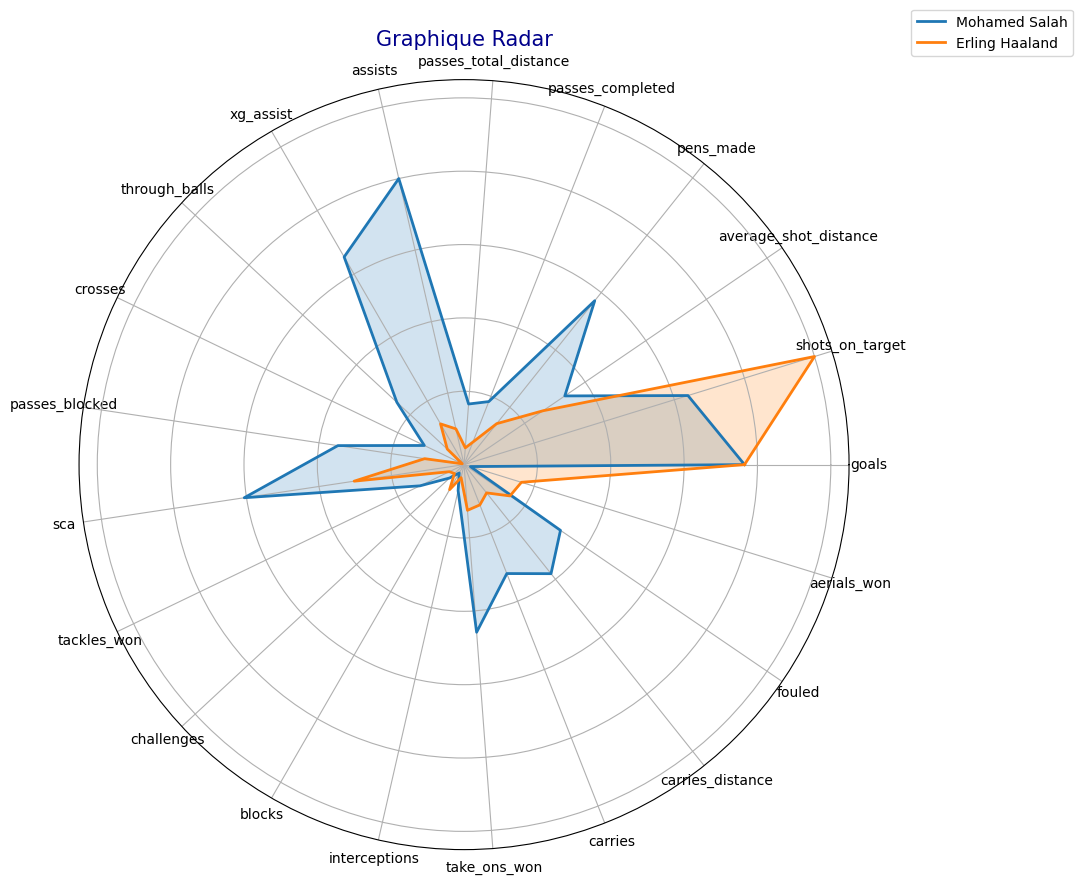

In [175]:
radar_plot_players(['Mohamed Salah','Erling Haaland'])

### Exploration d'un lien de corrélation entre l'aire d'un radar et la performance

In [178]:
na_player_ratings=player_ratings.isna()

In [197]:
import random
player_ratings_2024=dict([(player,player_ratings.loc[player,'2024-2025']) for player in player_ratings.index if not(na_player_ratings.loc[player,'2024-2025']) and not(na_player_stats_fbref.loc[player,'2024-2025'])])
ratings=list(player_ratings_2024.values())

areas=list(radar_plot_players(list(player_ratings_2024.keys()),return_area=True,show_radar=False).values())

sample_values=random.sample(list(np.arange(len(areas))),k=100)

Text(0.5, 1.0, 'Aire du radar en fonction de la note du joueur')

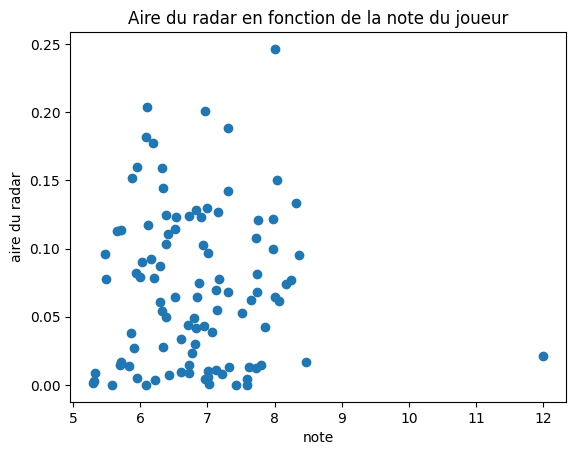

In [200]:
plt.scatter([ratings[i] for i in sample_values],[areas[i] for i in sample_values])
plt.xlabel('note')
plt.ylabel('aire du radar')
plt.title('Aire du radar en fonction de la note du joueur')

#### On observe pas de corrélation immédiate, le radar est donc un bon outil de visualisation pour voir comparer et voir directement certaines caractéristiques du jeu d'un joueur, mais il ne donne pas d'indication sur sa note

In [ ]:
import folium
from IPython.display import display
from folium.plugins import AntPath

def get_transfer_value(club,season):
    if club in transfer_history["GB1"][season].keys():
        transfer_fees = {'departures' : [], 'arrivals' : []}
        transfer_fees['arrivals'] = [fee[2]/1000 for fee in transfer_history["GB1"][season][club]["arrivals"] if type(fee[2])==float or type(fee[2])==int]
        for fee in transfer_history["GB1"][season][club]["departures"] :
            if type(fee[2])==float or type(fee[2])==int :
                transfer_fees['departures'].append(fee[2]/1000)
        return transfer_fees
    return {'departures' : [0], 'arrivals' : [0]}

data = pd.read_csv("pl_clubs_latlon.csv")




# Sélectionner la saison ici
season = 2024


center_lat = data['latitude'].mean()
center_lon = data['longitude'].mean()

mymap = folium.Map(location=[center_lat, center_lon], zoom_start=6)
valeur = 4
for _, row in data.iterrows():
    club = row['club_name']
    transferts = get_transfer_value(club, season)
    valeur = round(sum(transferts['departures']) + sum(transferts['arrivals']))
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,  # Rayon pondéré par la valeur marchande
        popup=f"{club}: {valeur}M€ \n Départs: {round(sum(transferts['departures']))}M€ \n Arrivées : {round(sum(transferts['arrivals']))}M€",
        color="blue",
        fill=True,
        fill_color="cyan",
        fill_opacity=0.6,
    ).add_to(mymap)
    if club in transfer_history["GB1"][season].keys():
        liste_departs = transfer_history["GB1"][season][club]["departures"]
        liste_arrivees = transfer_history["GB1"][season][club]["arrivals"]
        club_layer = folium.FeatureGroup(name=f"{club}", show=False)


        
        for transfert in liste_departs:
            if transfert[1] in list(data['club_name']):
                # Départ et arrivée
                depart = (
                    float(data[data['club_name'] == club]['latitude']),
                    float(data[data['club_name'] == club]['longitude']),
                )
                arrivee = (
                    float(data[data['club_name'] == transfert[1]]['latitude']),
                    float(data[data['club_name'] == transfert[1]]['longitude']),
                )
                
                # Ajouter une flèche au layer
                path = AntPath(
                    locations=[depart, arrivee],  # Liste des coordonnées
                    color="red",
                    weight=5,
                    opacity=0.8,
                ).add_to(club_layer)
                path.add_child(folium.Popup(f"Joueur: {transfert[0]} \n {transfert[2]}"))
                club_layer.add_child(path)

        for transfert in liste_arrivees:
            if transfert[1] in list(data['club_name']):
                # Départ et arrivée
                arrivee = (
                    float(data[data['club_name'] == club]['latitude']),
                    float(data[data['club_name'] == club]['longitude']),
                )
                depart = (
                    float(data[data['club_name'] == transfert[1]]['latitude']),
                    float(data[data['club_name'] == transfert[1]]['longitude']),
                )
                
                # Ajouter une flèche au layer
                path = AntPath(
                    locations=[depart, arrivee],  # Liste des coordonnées
                    color="green",
                    weight=5,
                    opacity=0.8,
                ).add_to(club_layer)
                path.add_child(folium.Popup(f"Joueur: {transfert[0]} \n {transfert[2]}"))
                club_layer.add_child(path)

        # Ajouter la couche à la carte
    club_layer.add_to(mymap)    

folium.LayerControl(collapsed=True).add_to(mymap)



# Sauvegarder la carte et l'afficher
mymap.save("carte_interactive.html")
display(mymap)


C:\Users\massi\AppData\Local\Temp\ipykernel_24076\2449493347.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data[data['club_name'] == club]['latitude']),
C:\Users\massi\AppData\Local\Temp\ipykernel_24076\2449493347.py:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data[data['club_name'] == club]['longitude']),
C:\Users\massi\AppData\Local\Temp\ipykernel_24076\2449493347.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(data[data['club_name'] == transfert[1]]['latitude']),
C:\Users\massi\AppData\Local\Temp\ipykernel_24076\2449493347.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.il